# RMF and images

RMFs are historically stored in a compressed form, which saves space - and *maybe* some evaluation time, but is annoying to work with. Images are nicer.

In [1]:
from importlib.metadata import version
version("sherpa")

'4.17.0'

In [2]:
from matplotlib import pyplot as plt

import numpy as np

# Add units just for completeness; at the time of writing Sherpa does not use / care about these 
from astropy import units as u

from sherpa.astro.data import DataPHA, DataARF, DataRMF
from sherpa.astro.instrument import matrix_to_rmf

For now pick a Chandra imaging-mode like setup:

In [3]:
detchans = 1024
emin = 0.3 * u.keV
emax = 12.0 * u.keV

egrid = np.linspace(emin, emax, detchans + 1)
energ_lo = egrid.value[:-1]
energ_hi = egrid.value[1:]

The idea is that we need a PHA, RMF, and ARF. As I'm not actually using the PHA data values we just care about the channels, and I am using a flat ARF since this notebook is more about the RMF variations:

In [4]:
texp = 10000 * u.s
chans = np.arange(1, detchans + 1, dtype=np.int16)
counts = np.zeros_like(chans)
pha1 = DataPHA("fake", chans, counts, exposure=texp.value)

In [5]:
specresp = 2000 * np.ones_like(energ_lo)
arf = DataARF("fake-arf", energ_lo, energ_hi, specresp)

I have a basic routine that will convert a 2D image / matrix into a RMF:

In [6]:
def make_rmf(img: np.ndarray,
             energ_lo: np.ndarray,
             energ_hi: np.ndarray,
             e_min: np.ndarray,
             e_max: np.ndarray
            ) -> DataRMF:
    """Convert the image into a RMF."""

    if img.ndim != 2:
        raise ValueError("img must be 2D")

    n_energy, n_chans = img.shape
    if (n_energy != energ_lo.size) or (energ_lo.size != energ_hi.size):
        raise ValueError("energ_lo/hi does not match the image Y axis")

    if (n_chans != e_min.size) or (e_min.size != e_max.size):
        raise ValueError("e_min/max does not match the image X axis")

    # We could set ethresh to matrix.min() but I'm not sure that is
    # the best idea, so ignore it for now.
    #
    n_grp, f_chan, n_chan, matrix = matrix_to_rmf(img)
    rmf = DataRMF("image", detchans=n_chans, energ_lo=energ_lo,
                  energ_hi=energ_hi, n_grp=n_grp, n_chan=n_chan,
                  f_chan=f_chan, matrix=matrix, offset=1, e_min=e_min,
                  e_max=e_max)
    return rmf

For now, let's create the identity matrix (aka a perfect response):

In [7]:
img1 = np.identity(detchans)
rmf1 = make_rmf(img1, energ_lo, energ_hi, energ_lo, energ_hi)

In [8]:
pha1.set_rmf(rmf1)
pha1.set_arf(arf)

pha1.set_analysis("energy")

For these examples we use an absorbed apec model; the actual values don't really matter but they do show some structure in the energy range of interest!

In [9]:
from sherpa.astro import xspec

mdl1 = xspec.XSphabs()
mdl2 = xspec.XSapec()
mdl = mdl1 * mdl2

# Avoid the "Reading APEC data from ...." message the first time the APEC model
# is evaluated
xspec.set_xschatter(0)

Here I use the Sherpa plot objects directly - it's essentially the same as `plot_model` and `plot_source` in the Sherpa UI layer:

In [10]:
from sherpa.astro.plot import ModelHistogram, SourcePlot

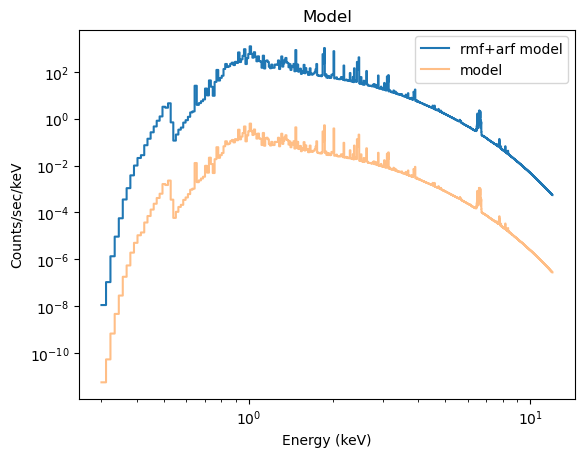

In [11]:
mplot1 = ModelHistogram()

resp1 = pha1.get_full_response()
mplot1.prepare(pha1, resp1(mdl))

mplot1.plot(xlog=True, ylog=True, label="rmf+arf model")

splot1 = SourcePlot()
splot1.prepare(pha1, mdl)
splot1.overplot(alpha=0.5, label="model")

Now, the two differences here are the ARF (which has a value of `2000`) and the exposure time (of `10000 s`). However, both plots are rates, so the exposure time is not an issue here. The spectral response (aka ARF) is, since the model includes that, which explains why the model + response is larger. We can compare the y values and see that the difference is (to within numerical accuracy concerns), `2000`: 

In [12]:
set(mplot1.y / splot1.y)

{1999.9999999999993,
 1999.9999999999995,
 1999.9999999999998,
 2000.0,
 2000.0000000000002,
 2000.0000000000005,
 2000.0000000000007}

# Simple blurring

Can we change the matrix to add some blurring? We could convolve `img1` by a simple shape:

In [13]:
blur = np.asarray([0.1, 0.2, 0.4, 0.2, 0.1])

img2 = np.zeros_like(img1)
for idx, row in enumerate(img1):
    img2[idx] = np.convolve(row, blur, mode="same") 

We can display the two images to see the difference, although given the data it isn't the easiest way to see the difference:

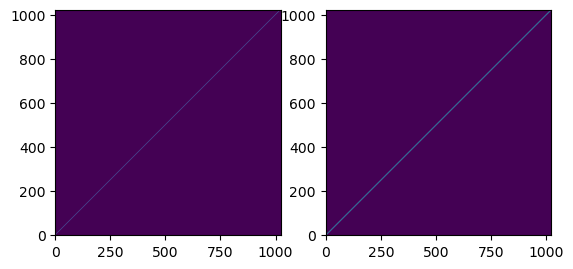

In [14]:
plt.subplot(1, 2, 1)
plt.imshow(img1, origin="lower")

plt.subplot(1, 2, 2)
plt.imshow(img2, origin="lower");

We can plot the same row from the two images and see the difference:

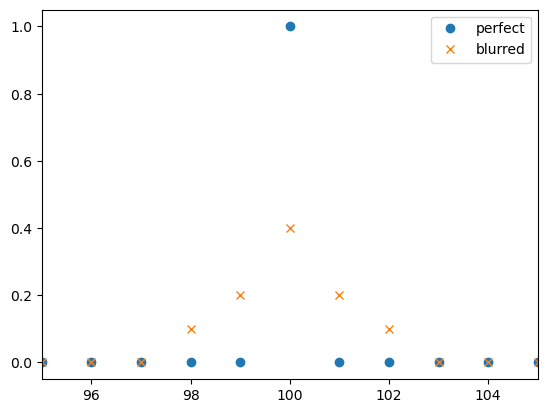

In [15]:
plt.plot(img1[100], "o", label="perfect")
plt.plot(img2[100], "x", label="blurred")

plt.xlim(95, 105)
plt.legend();

This "blurred" image can be converted to a RMF as above:

In [16]:
rmf2 = make_rmf(img2, energ_lo, energ_hi, energ_lo, energ_hi)

pha2 = DataPHA("fake", chans, counts, exposure=texp.value)
pha2.set_rmf(rmf2)
pha2.set_arf(arf)

pha2.set_analysis("energy")

This lets us compare the "observed" spectra (for the "perfect" and "blurred" cases). Note that edge effects are present here (for real-world data the
setup is normally such that we can ignore this but here there are subtle differences for the start and end channels:

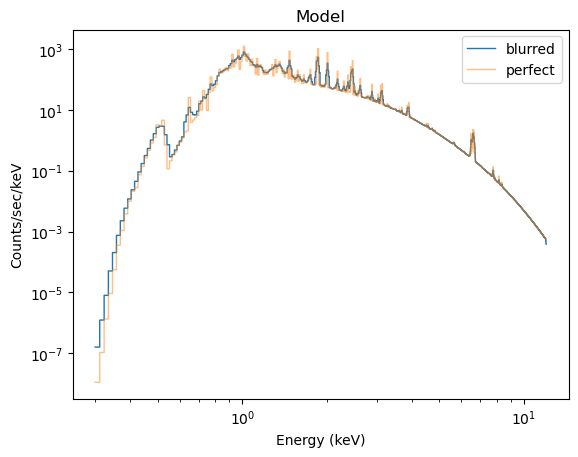

In [17]:
mplot2 = ModelHistogram()

resp2 = pha2.get_full_response()
mplot2.prepare(pha2, resp2(mdl))

mplot2.plot(xlog=True, ylog=True, linewidth=1, label="blurred")
mplot1.overplot(alpha=0.5, linewidth=1, label="perfect")

# Let's use a model for the RMF

We can apply any sort of model to create the matrix, including Sherpa ones...

In this case I use the normalized-gaussian (so I don't have to worry about the amplitude) and multiply it by a 1D box to restrict the data for each row. The gaussian is centered perfectly, and has a FWHM $\sim e^{-E / 8}$ for no other reason than it varied non-linearly across the energy range and came up with values not too crazy for the demonstration.

Now, to get the normalization of the gaussian correct we need to evaluate the model across each bin - that is, give the low and high edges of each bin - but we want the "box" model to act just as a "go / no-go" filter (so values of 1 or 0) and so we turn off the integrate flag for it.

In [18]:
from sherpa.models.basic import NormGauss1D, Box1D

# We want a bounded gaussian, so use Box1D * NormGauss1D.
#
ng = NormGauss1D()
bx = Box1D()
tmdl = bx * ng
ng.ampl = 1.0
bx.ampl = 1.0

# We don't want the box to be integrated, as all we use this
# for is to restrict the gaussian signal.
bx.integrate = False

img3 = np.zeros((detchans, detchans))
for idx, (elo, ehi) in enumerate(zip(energ_lo, energ_hi)):

    emid = (elo + ehi) / 2
    
    # Select a FWHM and position based on the energy
    ng.pos = emid
    ng.fwhm = np.exp(-emid / 8)

    # Bound the grid; pick 3 sigma because we can, which
    # is approximately 1.27 FWHM.
    bx.xlow = emid - 1.27 * ng.fwhm
    bx.xhi = emid + 1.27 * ng.fwhm

    # As we want the gaussian to be normalised to unity we
    # provide the bin edges (so the model is integrated across
    # each bin).
    img3[idx] = tmdl(energ_lo, energ_hi)

The resulting image shows more structure than before:

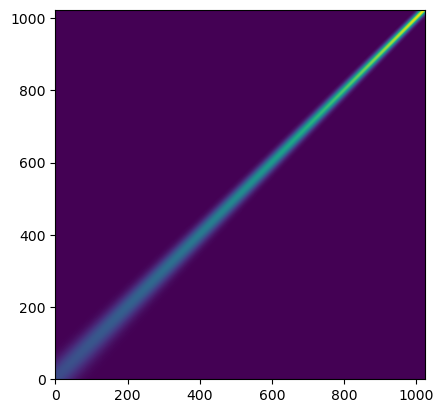

In [19]:
plt.imshow(img3, origin="lower");

We can see that it is much harder to detect individual lines with this RMF!

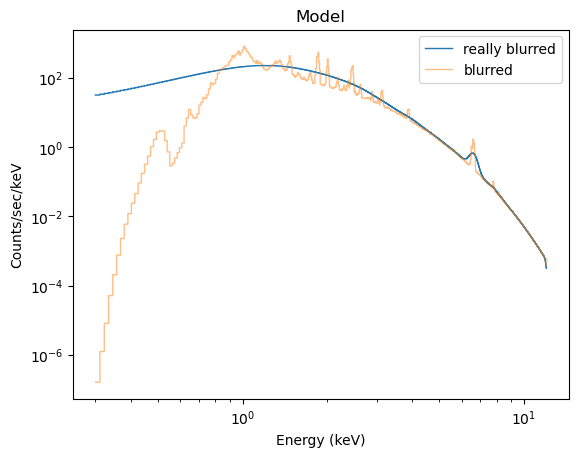

In [20]:
rmf3 = make_rmf(img3, energ_lo, energ_hi, energ_lo, energ_hi)

pha3 = DataPHA("fake", chans, counts, exposure=texp.value)
pha3.set_rmf(rmf3)
pha3.set_arf(arf)

pha3.set_analysis("energy")

mplot3 = ModelHistogram()

resp3 = pha3.get_full_response()
mplot3.prepare(pha3, resp3(mdl))

mplot3.plot(xlog=True, ylog=True, linewidth=1, label="really blurred")
mplot2.overplot(alpha=0.5, linewidth=1, label="blurred")

# How do we change the binning?

At present we have used a square matrix - that is, there are as many energy bins as the number of channels. However, there is no reason why they should
be the same. Unfortunately this means coming up with

- the energy grid to evaluate the model on (which is normally easy to do)
- the choice of the energy grid to represent the channels